## Notebook to analyse harmonisation variations

Compute the Combat parameters with different number of subjects and apply them to data 

Used to estimate a robust number of subjects to use for harmonisation

In [ ]:
import neuroCombat as nc
from meld_classifier.meld_cohort import MeldCohort, MeldSubject
import numpy as np
import pandas as pd
import meld_classifier.distributedCombat as dc
import pickle
import h5py
from neuroCombat import neuroCombat, neuroCombatFromTraining
import matplotlib.pyplot as plt

In [2]:
def load_covars( subject_ids=None, demographic_file=None,cohort=None):
        
        covars = pd.DataFrame()
        ages = []
        sex = []
        group = []
        sites_scanners = []
        for subject in subject_ids:
            subj = MeldSubject(subject, cohort=cohort)
            a, s = subj.get_demographic_features(["Age at preop", "Sex"], csv_file = demographic_file)
            ages.append(a)
            sex.append(s)
            group.append(subj.is_patient)
            sites_scanners.append(subj.site_code + "_" + subj.scanner)

        covars["ages"] = ages
        covars["sex"] = sex
        covars["group"] = group
        covars["site_scanner"] = sites_scanners
        covars["ID"] = subject_ids

        #clean missing values in demographics
        covars["ages"] = covars.groupby("site_scanner").transform(lambda x: x.fillna(x.mean()))["ages"]
        covars["sex"] = covars.groupby("site_scanner").transform(lambda x: x.fillna(np.random.choice([0, 1])))["sex"]
        return covars

def read_norm_combat_parameters(feature, hdf5_file):
        """reconstruct estimates dictionnary from the combat parameters hdf5 file"""
        hdf5_file_context = h5py.File(hdf5_file, "r")
        estimates = {}
        with hdf5_file_context as f:
            feat_dir = f[feature]
            parameters = feat_dir.keys()
            for param in parameters:
                if feat_dir[param].dtype == "S10":
                    estimates[param] = feat_dir[param].attrs["values"].astype(np.str)
                else:
                    estimates[param] = feat_dir[param][:]
        return estimates

def unshrink_combat_estimates( estimates):
    """ unshrink combat estimates to use as input in neuroCombatFromTraining"""
    num_subjects = estimates['num_subjects'][0]
    mod_mean = np.zeros((len(estimates['stand.mean']),num_subjects ))
    estimates['mod.mean'] = mod_mean
    estimates['stand.mean'] = np.tile(estimates['stand.mean'], (num_subjects,1)).T
    return estimates

def shrink_combat_estimates(estimates):
    """ shrink combat estimates to reduce size file"""
    #combined mod.mean with stand.mean
    stand_mean =  estimates['stand.mean'][:, 0] + estimates['mod.mean'].mean(axis=1)
    estimates['stand.mean'] = stand_mean
    #save the number of subjects to un-shrink later
    estimates['num_subjects']= np.array([estimates['mod.mean'].shape[1]])
    #remove mod.mean to reduce estimates size
    del estimates['mod.mean']
    return estimates

def save_norm_combat_parameters( feature, estimates, hdf5_file):
    """Save estimates from combat and normalisation parameters on hdf5"""
    if not os.path.isfile(hdf5_file):
        hdf5_file_context = h5py.File(hdf5_file, "a")
    else:
        hdf5_file_context = h5py.File(hdf5_file, "r+")

    with hdf5_file_context as f:
        list_params = list(set(estimates))
        for parameter_name in list_params:
            parameter = estimates[parameter_name]
            parameter = np.array(parameter)
            dtype = parameter.dtype
            dtype = parameter.dtype

            group = f.require_group(feature)
            if dtype == "O":
                dset = group.require_dataset(
                    parameter_name, shape=np.shape(parameter), dtype="S10", compression="gzip", compression_opts=9
                )
                dset.attrs["values"] = list(parameter)
            else:
                dset = group.require_dataset(
                    parameter_name, shape=np.shape(parameter), dtype=dtype, compression="gzip", compression_opts=9
                )
                dset[:] = parameter
    return

In [3]:
#bit for calculating combat estimates
site_code = 'H101'
c_smooth= MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_smoothed_6_kernels_NewSite.hdf5', 
                     )
    #create object combat
c_smooth.meld_dir = ''
listids = c_smooth.get_subject_ids(site_codes=['H101'])

#v defines specific filenames
features = c_smooth.get_features()
feature = features[7]

In [4]:
#define the splits of the data
cohorts = {}
rng = np.random.RandomState(42)
rng.shuffle(listids)
gold_list = listids[:100]
sub_cohort = listids[100:]
cohorts['gold'] = gold_list
for i in [3,5,10,15,20,25,30,35,40,45,50,70]:
    cohorts[str(i)] = rng.choice(sub_cohort, i, replace=False)



In [5]:
def compute_estimates(feature,listids, c_smooth,site_code,v):
    precombat_features, new_site_covars = load_data_estimates(feature,listids, c_smooth)
    combat_it(new_site_covars, precombat_features, feature, v,site_code)
    return

In [7]:
#loading
def load_data_estimates(feature, listids,c_smooth):
    precombat_features=[]
    combat_subject_include = np.zeros(len(listids), dtype=bool)
    demos=[]
    for k, subject in enumerate(listids):
        # get the reference index and cohort object for the site, 0 whole cohort, 1 new cohort
        subj = MeldSubject(subject, cohort=c_smooth)
        # exclude outliers and subject without feature
        if (subj.has_features(feature)) :
            lh = subj.load_feature_values(feature, hemi="lh")[c_smooth.cortex_mask]
            rh = subj.load_feature_values(feature, hemi="rh")[c_smooth.cortex_mask]
            combined_hemis = np.hstack([lh, rh])
            precombat_features.append(combined_hemis)
            combat_subject_include[k] = True
        else:
            combat_subject_include[k] = False
    new_site_covars = load_covars(subject_ids=np.array(listids)[np.array(combat_subject_include)],
        demographic_file='MELD_H101/demographics_file.csv',
            cohort = c_smooth).copy()
    return precombat_features, new_site_covars

In [8]:
def combat_it(new_site_covars, precombat_features, feature, v,site_code):
    site_scanner = new_site_covars['site_scanner'].unique()[0]
    bat = pd.Series(pd.Categorical(np.array(new_site_covars['site_scanner']),
                                        categories=['H0', site_scanner]))     
    new_site_data = np.array(precombat_features).T 
    site_combat_path = 'combat_params_test'
    dc.distributedCombat_site(new_site_data,
                                    bat, 
                                    new_site_covars[['ages','sex','group']], 
                                    file=os.path.join(site_combat_path,f"{site_code}_{feature}_summary_{v}.pickle"), 
                                ref_batch = 'H0', 
                                robust=True,)
    meld_combat_path = os.path.join(c_smooth.meld_dir,'distributed_combat_6_kernels_robustCombat')
    dc_out = dc.distributedCombat_central(
                [os.path.join(meld_combat_path,f'MELD_{feature}.pickle'),
                os.path.join(site_combat_path,f"{site_code}_{feature}_summary_{v}.pickle")], ref_batch = 'H0'
            )
            # third, use variance estimates from full MELD cohort
    dc_out['var_pooled'] = pd.read_pickle(os.path.join(meld_combat_path,f'MELD_{feature}_var.pickle')).ravel()
    for c in ['ages','sex','group']:
        new_site_covars[c]=new_site_covars[c].astype(np.float64)  
    pickle_file = os.path.join(site_combat_path,f"{site_code}_{feature}_harmonisation_params_test_{v}.pickle")
    _=dc.distributedCombat_site(
                pd.DataFrame(new_site_data), bat, new_site_covars[['ages','sex','group']], 
                file=pickle_file,
                central_out=dc_out, 
                ref_batch = 'H0', 
                robust=True,
            )
    with open(pickle_file, 'rb') as f:
                params = pickle.load(f)
            #filter name keys
    target_dict = {'batch':'batches', 'delta_star':'delta.star', 'var_pooled':'var.pooled',
        'gamma_star':'gamma.star', 'stand_mean':'stand.mean', 'mod_mean': 'mod.mean', 
        'parametric': 'del', 'eb':'del', 'mean_only':'del', 'mod':'del', 'ref_batch':'del', 'beta_hat':'del', 
        }
    estimates = params['estimates'].copy()
    for key in target_dict.keys():  
        if target_dict[key]=='del':
            estimates.pop(key)
        else:
            estimates[target_dict[key]] = estimates.pop(key)
    for key in estimates.keys():
        if key in ['a_prior', 'b_prior', 't2', 'gamma_bar']:
            estimates[key]=[estimates[key]]
        if key == 'batches':
            estimates[key]=np.array([estimates[key][0]]).astype('object')
        if key=='var.pooled':
            estimates[key]=estimates[key][:,np.newaxis]
        if key in ['gamma.star', 'delta.star']:
            estimates[key]=estimates[key][np.newaxis,:]
        estimates[key] = np.array(estimates[key])
    shrink_estimates = shrink_combat_estimates(estimates)
    #save estimates and delete pickle file
    combat_params_file=os.path.join('combat_params_test', f'H101_{feature}_harmonisation_params_test_{v}.hdf5')
    save_norm_combat_parameters(feature, shrink_estimates, combat_params_file)
    os.remove(pickle_file)
    pickle_file = os.path.join(site_combat_path,f"{site_code}_{feature}_summary_{v}.pickle")
    os.remove(pickle_file)
    return

In [9]:
#applying estimates parameters to a fixed dataset.
def get_applied_estimates(vs, feature, c_smooth,sub_cohort):
    site_scanner ='H101_3T'
    site_scanners = np.tile(site_scanner, len(sub_cohort))
    precombat_features, new_site_covars = load_data_estimates(feature,sub_cohort, c_smooth)
    precombat_features = np.array(precombat_features).astype(np.float32)
    applied = {}
    for v in vs:
        combat_params_file=os.path.join('combat_params_test', f'H101_{feature}_harmonisation_params_test_{v}.hdf5')
        combat_estimates = read_norm_combat_parameters(feature, combat_params_file)
        combat_estimates = unshrink_combat_estimates(combat_estimates)
        for k in combat_estimates.keys():
            if combat_estimates[k].dtype == np.float64:
                combat_estimates[k] = np.array(combat_estimates[k]).astype(np.float32)
        dict_combat = neuroCombatFromTraining(dat=precombat_features.T, batch=site_scanners, estimates=combat_estimates)
        applied[v] = dict_combat['data'][0]
    return applied

In [ ]:
for v in cohorts.keys():
    compute_estimates(feature, cohorts[v], c_smooth,site_code,v)

In [ ]:
vs=list(cohorts.keys())
applied = get_applied_estimates(vs, feature, c_smooth,sub_cohort)

In [ ]:
#compare the subjects to gold
corrs = np.zeros((len(vs), len(sub_cohort)))
for i, v in enumerate(vs):
    print(v)
    corrs[i] = np.array([np.corrcoef(applied[v][:,j], applied['gold'][:,j])[0,1] for j in range(applied[v].shape[1])])

In [ ]:
#raincloud plot
import seaborn as sns


/home/kw350/.conda/envs/meld_graph/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 97.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/kw350/.conda/envs/meld_graph/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 98.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


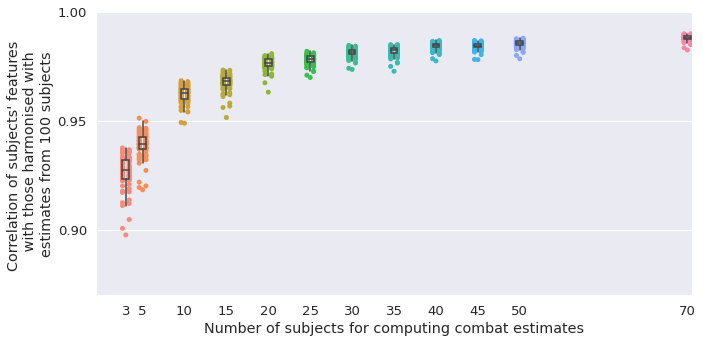

In [118]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
corr_list = []
labels = []
ticks = []
#set font size
#sns.set(font_scale=1.2)

for i, v in enumerate(vs):
    if v=='gold':
        
        continue
    else:
        #ax.scatter(np.tile(np.int(v), len(corrs[i])),corrs[i],label=v,c='r',s=10,marker='o')
        corr_list.extend(list(corrs[i]))
        labels.extend([np.int32(v)]*len(corrs[i]))
        ticks.extend([np.int32(v)])

for i in np.arange(70):
    corr_list.extend([5.0])
    labels.extend([i])
        
df = pd.DataFrame({'correlation':corr_list, 'Number of subjects':labels})
sns.swarmplot(x='Number of subjects', y='correlation', data=df,
      ax=ax )
sns.boxplot(x='Number of subjects', y='correlation', data=df, 
showcaps=False,boxprops={'facecolor':'None', "zorder":10},
                 showfliers=False,
                 ax=ax, zorder=10)
ax.set_ylim(0.87,1.0)
ax.set_yticks([0.9,0.95,1.0],fontsize=20)
ax.set_xticks(ticks,fontsize=20)
ax.set_xlabel('Number of subjects for computing combat estimates')
ax.set_ylabel("Correlation of subjects' features \n with those harmonised with\nestimates from 100 subjects")


fig.tight_layout()
fig.savefig('../figures/combat_estimates_correlation.pdf')